In [1]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax.experimental.ode import odeint
import numpy as np
import matplotlib.pyplot as plt
import optax

from flax import linen as nn
from flax.training import train_state
from jax import random

### Define the system

In [2]:
def harmonic_oscillator(state, t, omega_squared):
    x1, x2 = state
    dx1dt = x2
    dx2dt = -omega_squared * x1
    return jnp.array([dx1dt, dx2dt])

### Network Definition

In [3]:
class ParameterEstimator(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(64)(x)
        x = nn.tanh(x)
        x = nn.Dense(64)(x)
        x = nn.tanh(x)
        x = nn.Dense(1)(x)  # Output \(\omega^2\)
        return x

### Initialize

In [4]:
def create_train_state(rng, learning_rate):
    model = ParameterEstimator()
    params = model.init(rng, jnp.ones((2,)))['params'] 
    tx = optax.adam(learning_rate)
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

### Loss Function

In [7]:
def loss_fn(params, apply_fn, t, observed_data, y0):
    omega_squared = apply_fn({'params': params}, y0)[0]  # Predict omega^2 using initial state y0
    # print(omega_squared)
    # update the function to use the predicted omega^2
    def func(y, t):
        return harmonic_oscillator(y, t, omega_squared)
    
    pred_solution = odeint(func, y0, t)
    return jnp.mean((pred_solution - observed_data) ** 2)


### Training

In [8]:
@jax.jit
def train_step(state, t, observed_data, y0):
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params, state.apply_fn, t, observed_data, y0)
    state = state.apply_gradients(grads=grads)
    return state, loss

def train(state, t, observed_data, y0, num_epochs=1000, verbose=True):
    for epoch in range(num_epochs):
        state, loss = train_step(state, t, observed_data, y0)
        if epoch % 100 == 0 and verbose:
            print(f'Epoch {epoch}, Loss: {loss}')
    return state

### Data Generation
* omega_squared_true = 1.0

In [9]:
n_points = 100
t = jnp.linspace(0, 10, n_points)
y0 = jnp.array([1.0, 0.0])
omega_squared_true = 1.0
y = odeint(harmonic_oscillator, y0, t, omega_squared_true)

### Network Parameters

In [10]:
rng = random.PRNGKey(0)
learning_rate = 1e-3

### Train

In [11]:
# Initialize
state = create_train_state(rng, learning_rate)
trained_state = train(state, t, y, y0)

# Predict omega_squared using the trained model
omega_squared_pred = trained_state.apply_fn({'params': trained_state.params}, y0)[0]

Epoch 0, Loss: 0.9693307876586914
Epoch 100, Loss: 1.494158641435206e-05
Epoch 200, Loss: 6.63970822767368e-10
Epoch 300, Loss: 5.632010916661878e-12
Epoch 400, Loss: 2.8466673462901326e-12
Epoch 500, Loss: 9.180393424623734e-12
Epoch 600, Loss: 4.24616071470485e-12
Epoch 700, Loss: 4.8611926983799236e-11
Epoch 800, Loss: 3.69900074112528e-12
Epoch 900, Loss: 2.3339857824211663e-11


### Define solver

In [10]:
# Solve the ODE using the predicted parameter
def estimated_harmonic_oscillator(state, t, omega_squared):
    return harmonic_oscillator(state, t, omega_squared)

### Predict

Epoch 0, Loss: 0.9693307876586914
Epoch 100, Loss: 1.4909302990417928e-05
Epoch 200, Loss: 4.966038691378571e-10
Epoch 300, Loss: 3.1245639756094512e-12
Epoch 400, Loss: 3.1245639756094512e-12
Epoch 500, Loss: 3.1245639756094512e-12
Epoch 600, Loss: 3.1245639756094512e-12
Epoch 700, Loss: 3.1245639756094512e-12
Epoch 800, Loss: 8.1603812249198e-12
Epoch 900, Loss: 2.2953928688340675e-11


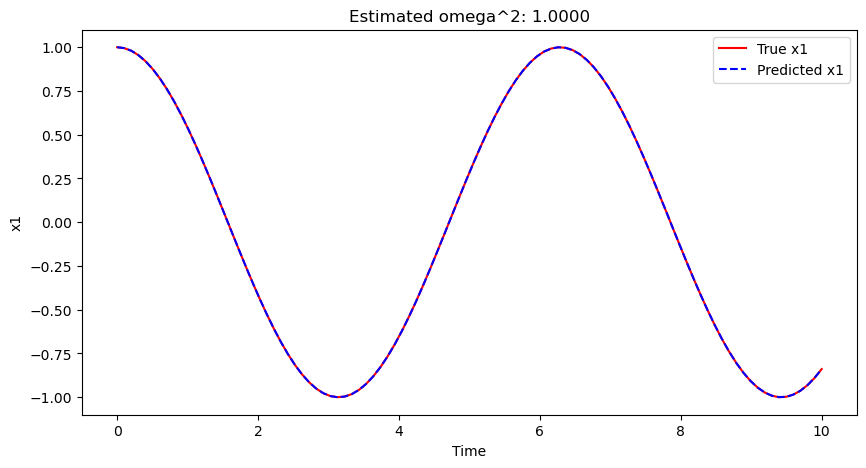

In [11]:
# Data
n_points = 100
t = jnp.linspace(0, 10, n_points)
y0 = jnp.array([1.0, 0.0])
omega_squared_true = 1.0
y = odeint(harmonic_oscillator, y0, t, omega_squared_true)

# Initialize
state = create_train_state(rng, learning_rate)
trained_state = train(state, t, y, y0)

# Predict omega_squared using the trained model
omega_squared_pred = trained_state.apply_fn({'params': trained_state.params}, y0)[0]
# print(trained_state.params)

y_pred = odeint(estimated_harmonic_oscillator, y0, t, omega_squared_pred)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(t, y[:, 0], 'r-', label='True x1')
plt.plot(t, y_pred[:, 0], 'b--', label='Predicted x1')
plt.xlabel('Time')
plt.ylabel('x1')
plt.legend()
plt.title(f'Estimated omega^2: {omega_squared_pred:.4f}')
plt.show()


### Data Generation
* omega_squared_true = 4.0

In [12]:
n_points = 100
t = jnp.linspace(0, 10, n_points)
y0 = jnp.array([1.0, 0.0])
omega_squared_true = 4.0
y = odeint(harmonic_oscillator, y0, t, omega_squared_true)

In [13]:
# Initialize
state = create_train_state(rng, learning_rate)
trained_state = train(state, t, y, y0)

# Predict omega_squared using the trained model
omega_squared_pred = trained_state.apply_fn({'params': trained_state.params}, y0)[0]

Epoch 0, Loss: 1.512216329574585
Epoch 100, Loss: 1.4767818450927734
Epoch 200, Loss: 1.476780652999878
Epoch 300, Loss: 1.4767810106277466
Epoch 400, Loss: 1.4767810106277466
Epoch 500, Loss: 1.4767810106277466
Epoch 600, Loss: 1.4767810106277466
Epoch 700, Loss: 1.4767810106277466
Epoch 800, Loss: 1.4767807722091675
Epoch 900, Loss: 1.4767810106277466


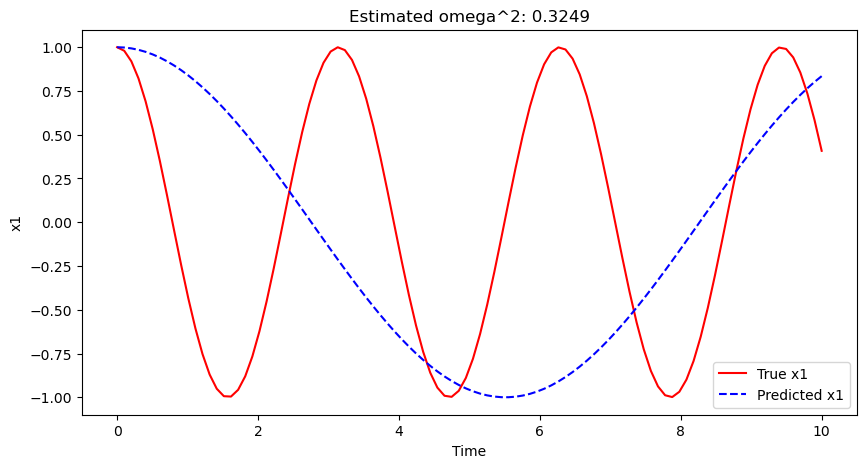

In [14]:
y_pred = odeint(estimated_harmonic_oscillator, y0, t, omega_squared_pred)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(t, y[:, 0], 'r-', label='True x1')
plt.plot(t, y_pred[:, 0], 'b--', label='Predicted x1')
plt.xlabel('Time')
plt.ylabel('x1')
plt.legend()
plt.title(f'Estimated omega^2: {omega_squared_pred:.4f}')
plt.show()


### Omega vs MSE

In [15]:
true_omega_squared_values = np.linspace(0.25, 5, 40)
true_omega_squared_values

array([0.25      , 0.37179487, 0.49358974, 0.61538462, 0.73717949,
       0.85897436, 0.98076923, 1.1025641 , 1.22435897, 1.34615385,
       1.46794872, 1.58974359, 1.71153846, 1.83333333, 1.95512821,
       2.07692308, 2.19871795, 2.32051282, 2.44230769, 2.56410256,
       2.68589744, 2.80769231, 2.92948718, 3.05128205, 3.17307692,
       3.29487179, 3.41666667, 3.53846154, 3.66025641, 3.78205128,
       3.90384615, 4.02564103, 4.1474359 , 4.26923077, 4.39102564,
       4.51282051, 4.63461538, 4.75641026, 4.87820513, 5.        ])

## n_points = 100

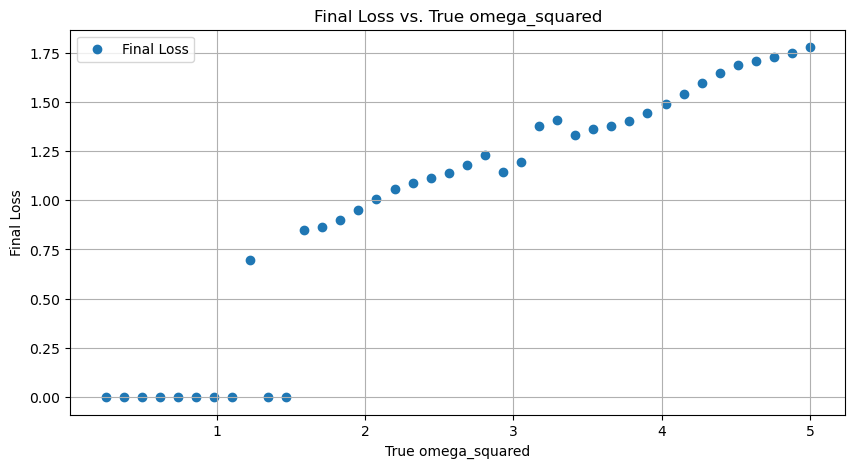

In [16]:
n_points = 100
t = jnp.linspace(0, 10, n_points)
y0 = jnp.array([1.0, 0.0])
learning_rate = 1e-3
rng = random.PRNGKey(0)

true_omega_squared_values = np.linspace(0.25, 5, 40)
final_losses = []

for omega_squared_true in true_omega_squared_values:
    y = odeint(harmonic_oscillator, y0, t, omega_squared_true)
    
    state = create_train_state(rng, learning_rate)
    trained_state = train(state, t, y, y0, verbose=False)
    
    omega_squared_pred = trained_state.apply_fn({'params': trained_state.params}, y0)[0]
    
    y_pred = odeint(estimated_harmonic_oscillator, y0, t, omega_squared_pred)
    final_loss = jnp.mean((y - y_pred) ** 2)
    
    final_losses.append(final_loss)

# Plot the results
plt.figure(figsize=(10, 5))
plt.scatter(true_omega_squared_values, final_losses, label='Final Loss')
plt.xlabel('True omega_squared')
plt.ylabel('Final Loss')
plt.legend()
plt.title('Final Loss vs. True omega_squared')
plt.grid(True)
plt.show()


## n_points = 50

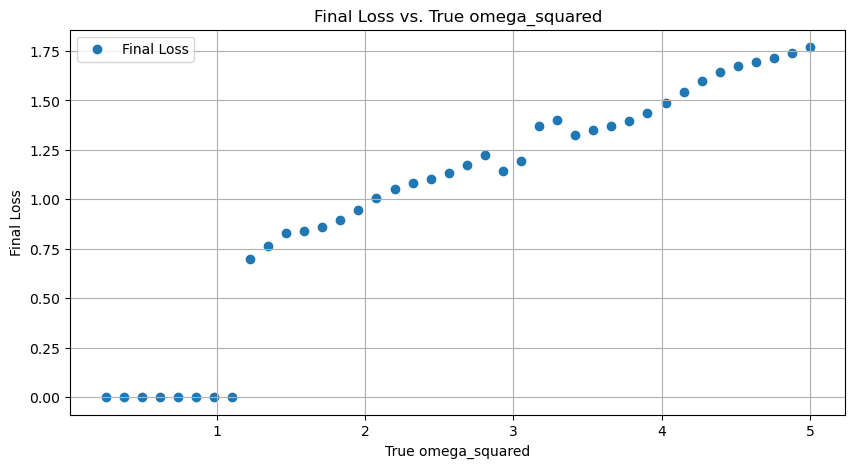

In [18]:
n_points = 50
t = jnp.linspace(0, 10, n_points)
y0 = jnp.array([1.0, 0.0])
learning_rate = 1e-3
rng = random.PRNGKey(0)

true_omega_squared_values = np.linspace(0.25, 5, 40)
final_losses = []

for omega_squared_true in true_omega_squared_values:
    y = odeint(harmonic_oscillator, y0, t, omega_squared_true)
    
    state = create_train_state(rng, learning_rate)
    trained_state = train(state, t, y, y0, verbose=False)
    
    omega_squared_pred = trained_state.apply_fn({'params': trained_state.params}, y0)[0]
    
    y_pred = odeint(estimated_harmonic_oscillator, y0, t, omega_squared_pred)
    final_loss = jnp.mean((y - y_pred) ** 2)
    
    final_losses.append(final_loss)

# Plot the results
plt.figure(figsize=(10, 5))
plt.scatter(true_omega_squared_values, final_losses, label='Final Loss')
plt.xlabel('True omega_squared')
plt.ylabel('Final Loss')
plt.legend()
plt.title('Final Loss vs. True omega_squared')
plt.grid(True)
plt.show()


## n_points = 200

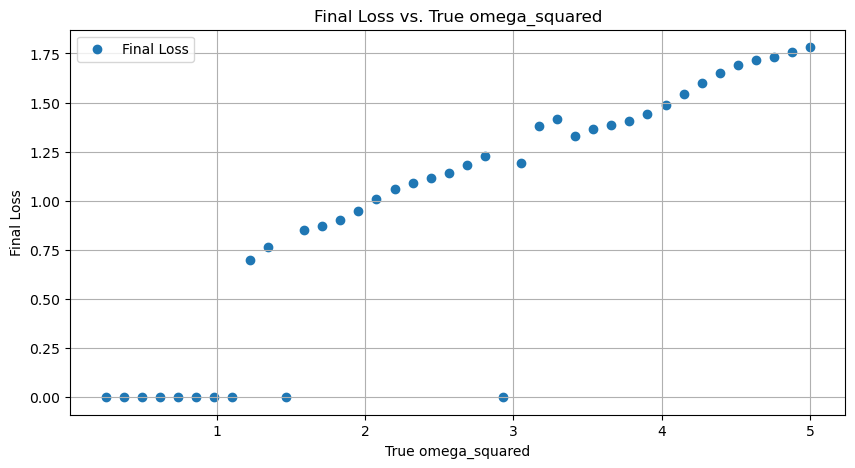

In [19]:
n_points = 200
t = jnp.linspace(0, 10, n_points)
y0 = jnp.array([1.0, 0.0])
learning_rate = 1e-3
rng = random.PRNGKey(0)

true_omega_squared_values = np.linspace(0.25, 5, 40)
final_losses = []

for omega_squared_true in true_omega_squared_values:
    y = odeint(harmonic_oscillator, y0, t, omega_squared_true)
    
    state = create_train_state(rng, learning_rate)
    trained_state = train(state, t, y, y0, verbose=False)
    
    omega_squared_pred = trained_state.apply_fn({'params': trained_state.params}, y0)[0]
    
    y_pred = odeint(estimated_harmonic_oscillator, y0, t, omega_squared_pred)
    final_loss = jnp.mean((y - y_pred) ** 2)
    
    final_losses.append(final_loss)

# Plot the results
plt.figure(figsize=(10, 5))
plt.scatter(true_omega_squared_values, final_losses, label='Final Loss')
plt.xlabel('True omega_squared')
plt.ylabel('Final Loss')
plt.legend()
plt.title('Final Loss vs. True omega_squared')
plt.grid(True)
plt.show()


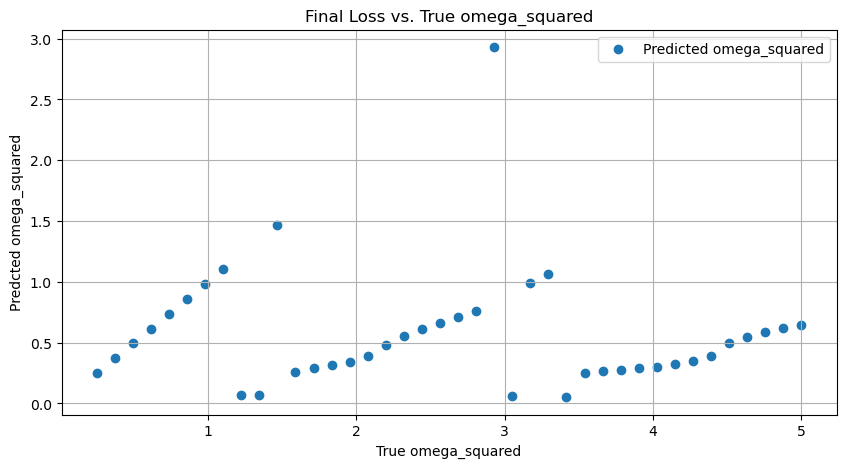

In [20]:
n_points = 200
t = jnp.linspace(0, 10, n_points)
y0 = jnp.array([1.0, 0.0])
learning_rate = 1e-3
rng = random.PRNGKey(0)

true_omega_squared_values = np.linspace(0.25, 5, 40)
omega_squared_pred_li = []

for omega_squared_true in true_omega_squared_values:
    y = odeint(harmonic_oscillator, y0, t, omega_squared_true)
    
    state = create_train_state(rng, learning_rate)
    trained_state = train(state, t, y, y0, verbose=False)
    
    omega_squared_pred = trained_state.apply_fn({'params': trained_state.params}, y0)[0]
    
    omega_squared_pred_li.append(omega_squared_pred)

# Plot the results
plt.figure(figsize=(10, 5))
plt.scatter(true_omega_squared_values, omega_squared_pred_li, label='Predicted omega_squared')
plt.xlabel('True omega_squared')
plt.ylabel('Predcted omega_squared')
plt.legend()
plt.title('Final Loss vs. True omega_squared')
plt.grid(True)
plt.show()
